# Noiseness analysis

These cells assume that each JSON file is named in the form "seed_iteration" (for example, "23_1.json", "23_2.json", …, "23_10.json") and that each file contains fitness data for a simulation run on a fixed track (the seed). 
This approach lets you compute the noisiness and the variability across simulation runs for the same track -> to quantify how stable or noisy each track’s outcomes are.

In [15]:
# # Noiseness analysis
#
# These cells assume that each JSON file is named in the form "seed_iteration" (for example, "23_1.json", "23_2.json", …, "23_10.json") and that each file contains fitness data for a simulation run on a fixed track (the seed).  
# In this section we first analyze the variability (noiseness) among all simulation runs. Later, we aggregate (average) the 10 runs for each seed to obtain one result per track, which we use for further visual analyses.

# %% 
import os
import json
import pandas as pd

# Define directories for Voronoi-based and Convex Hull–based tracks.
DATA_DIRS = {
    'voronoi': './voronoi',
    'convexHull': './convexHull'
}

def load_simulation_data(folder, technique):
    records = []
    for fname in os.listdir(folder):
        if not fname.endswith('.json'):
            continue
        base = os.path.splitext(fname)[0]
        parts = base.split('_')
        if len(parts) < 2:
            continue
        try:
            seed = int(parts[0])
            iteration = int(parts[1])
        except Exception:
            continue
        path = os.path.join(folder, fname)
        try:
            with open(path, 'r', encoding='utf-8') as file:
                data = json.load(file)
            fitness = data.get('fitness')
            if not fitness:
                continue
            fitness['seed'] = seed
            fitness['iteration'] = iteration
            fitness['technique'] = technique
            records.append(fitness)
        except Exception as err:
            print(f"Error reading {fname}: {err}")
    return pd.DataFrame(records)

dfs = []
for tech, folder in DATA_DIRS.items():
    df_tech = load_simulation_data(folder, tech)
    print(f"Loaded {len(df_tech)} records from {tech}.")
    dfs.append(df_tech)
# This dataframe (df_all) contains all individual runs (10 per seed, over both techniques).
df_all = pd.concat(dfs, ignore_index=True)
print("Combined data sample (all simulation runs):")


Loaded 993 records from voronoi.
Loaded 1000 records from convexHull.
Combined data sample (all simulation runs):


Visualize noisiness for selected features with error bar plots.

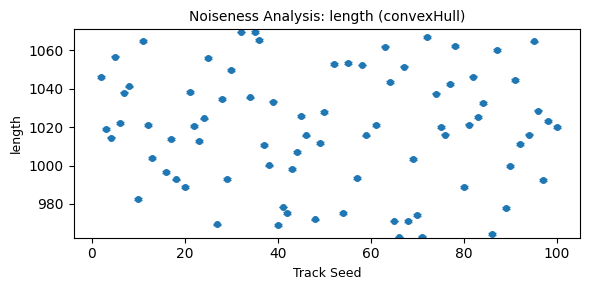

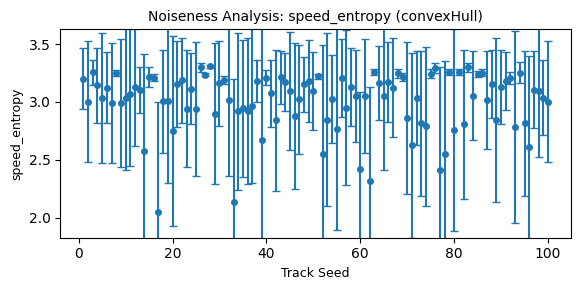

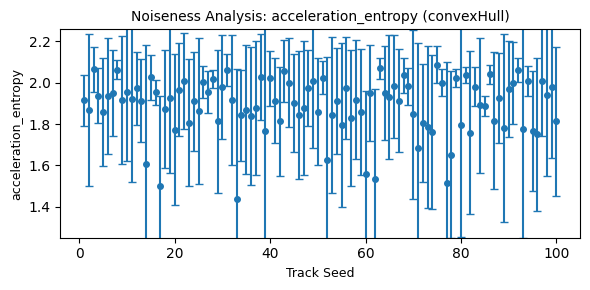

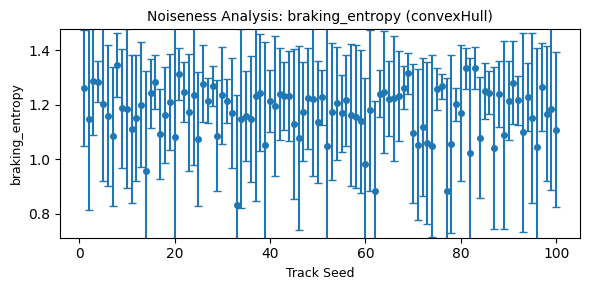

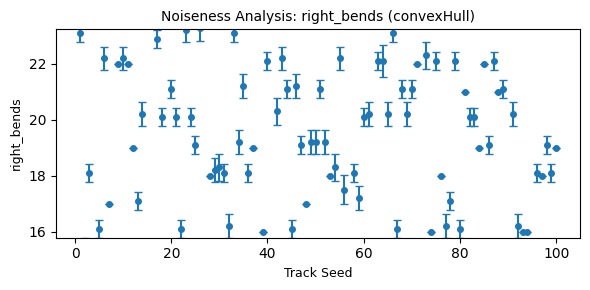

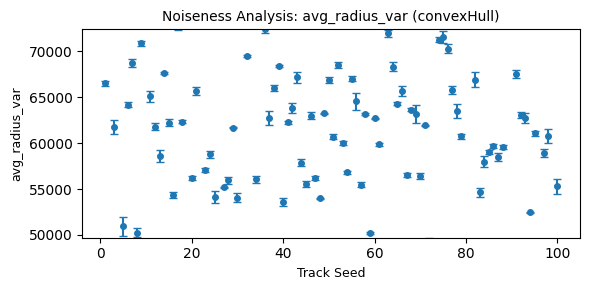

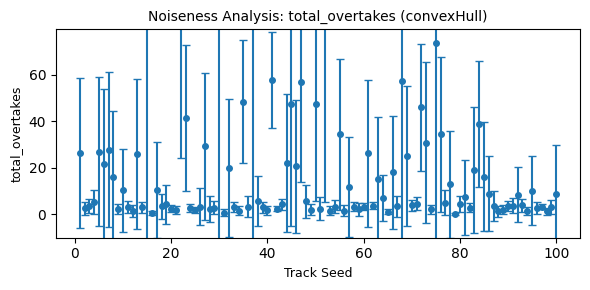

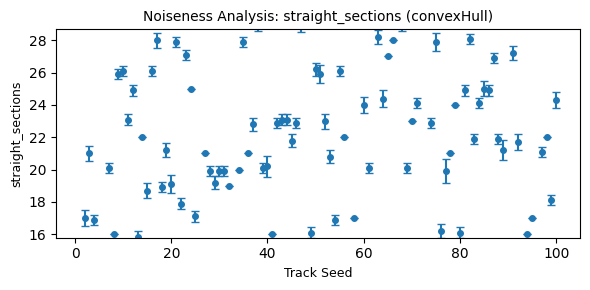

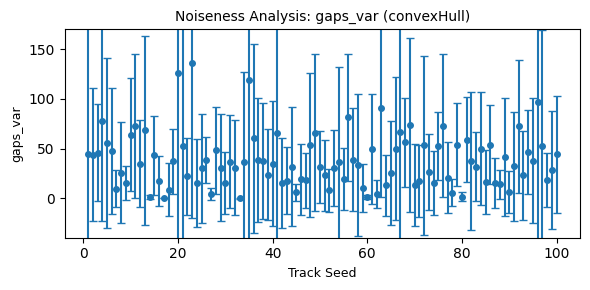

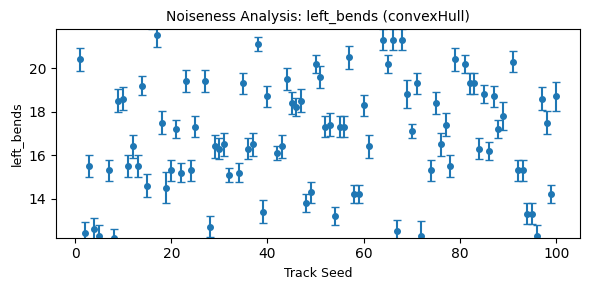

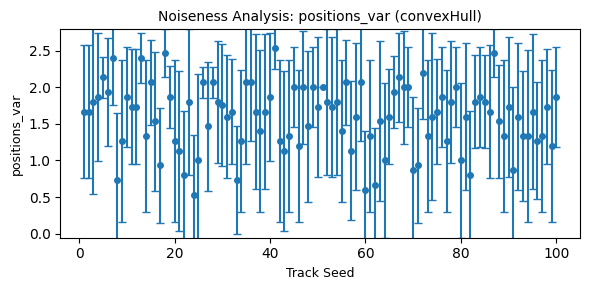

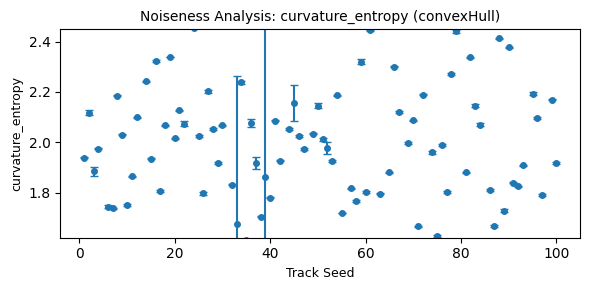

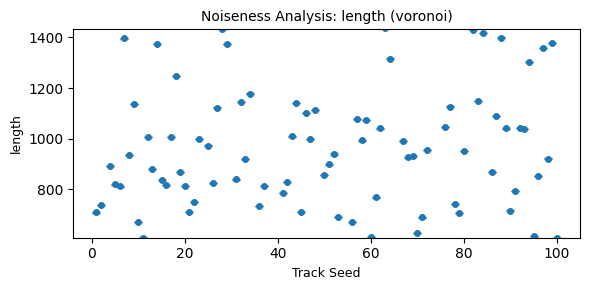

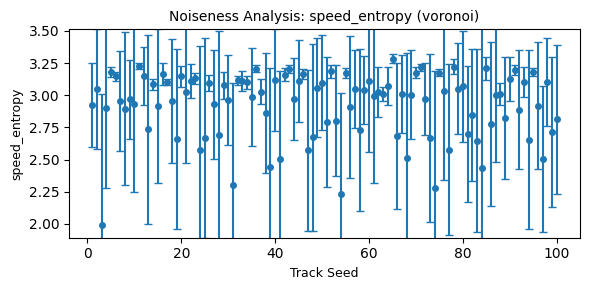

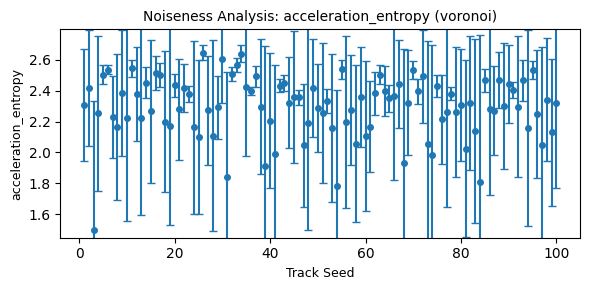

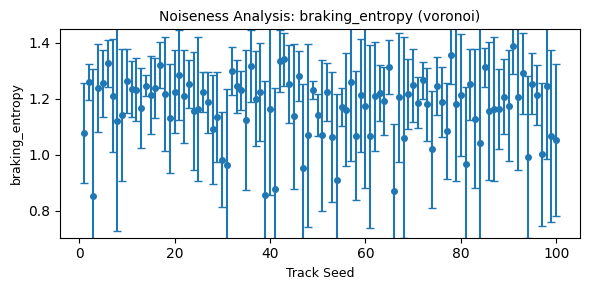

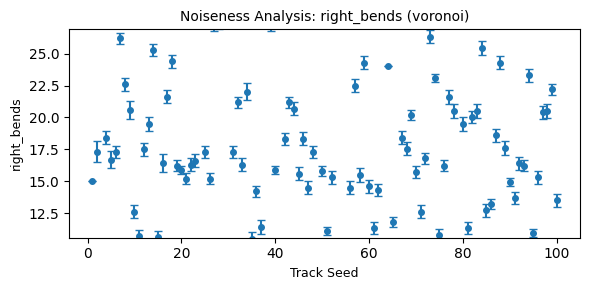

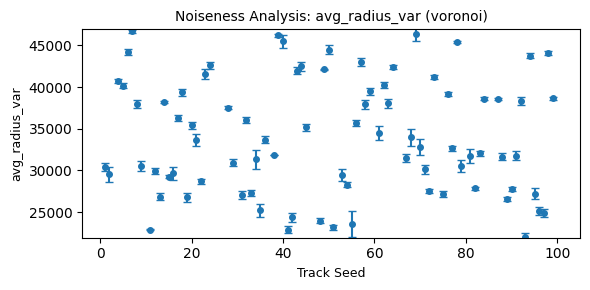

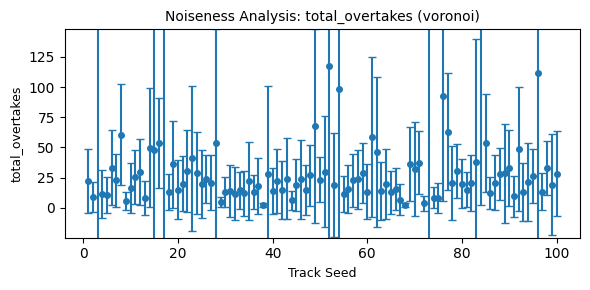

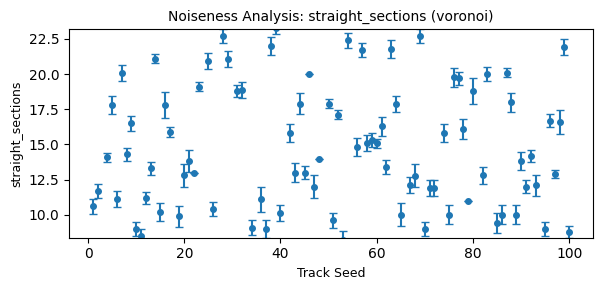

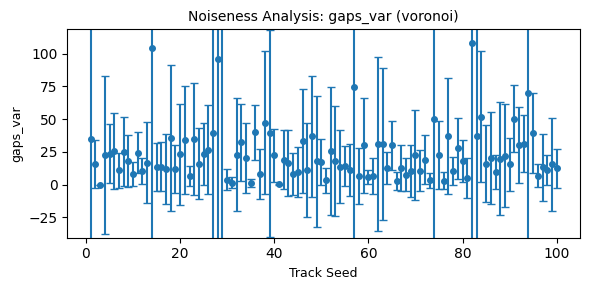

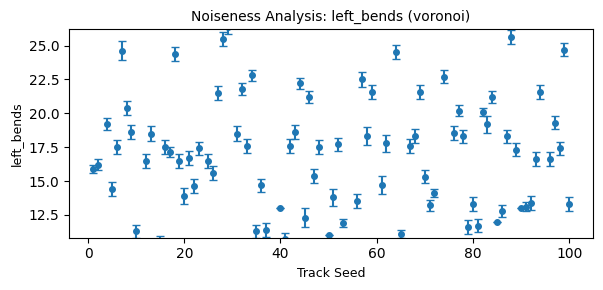

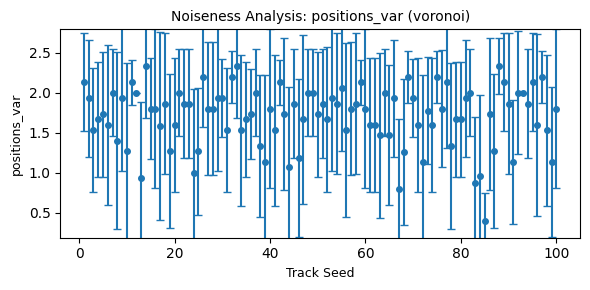

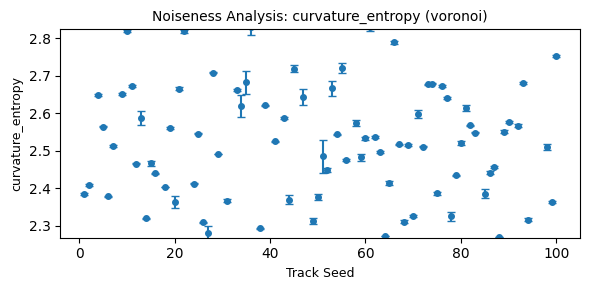

In [28]:
# %% [markdown]
# ## Noiseness visualization: error bar plots per feature (excluding deltaX, deltaY, deltaAngleDegrees)
#
# Here we examine the variation (mean and standard deviation) across the different simulation runs for each track,
# but we only consider features such as curvature_entropy, gaps, overtakes, etc.

# %% 
import matplotlib.pyplot as plt

def flatten_columns(columns):
    new_cols = []
    for col in columns:
        if isinstance(col, tuple):
            new_cols.append('_'.join(filter(None, col)))
        else:
            new_cols.append(col)
    return new_cols

# Compute per-seed statistics for all runs.
group_stats_all = df_all.groupby(['technique', 'seed']).agg(['mean', 'std']).reset_index()
group_stats_all.columns = flatten_columns(group_stats_all.columns)

techniques = group_stats_all['technique'].unique()

# Exclude deltaX, deltaY, and deltaAngleDegrees from the features.
exclude_features = ['seed', 'iteration', 'technique', 'deltaX', 'deltaY', 'deltaAngleDegrees']
features = [col for col in df_all.columns if col not in exclude_features]

for tech in techniques:
    stats_tech = group_stats_all[group_stats_all['technique'] == tech]
    metric_names = [col.replace('_mean', '') for col in stats_tech.columns 
                    if col.endswith('_mean') and col.replace('_mean', '') not in ['seed']]
    metric_names = [m for m in metric_names if m in features]
    for metric in metric_names:
        plt.figure(figsize=(6, 3))
        mean_col = f"{metric}_mean"
        std_col = f"{metric}_std"
        plt.errorbar(stats_tech["seed"], stats_tech[mean_col],
                     yerr=stats_tech[std_col],
                     fmt="o", capsize=3, markersize=4)
        # Compute lower and upper bounds (mean minus/plus std)
        lower_bounds = stats_tech[mean_col] - stats_tech[std_col]
        upper_bounds = stats_tech[mean_col] + stats_tech[std_col]
        # Set y-axis limits from 5th percentile of lower bounds to 95th percentile of upper bounds
        low_lim = np.percentile(lower_bounds.dropna(), 10)
        high_lim = np.percentile(upper_bounds.dropna(), 90)
        plt.ylim(low_lim, high_lim)
        plt.xlabel("Track Seed", fontsize=9)
        plt.ylabel(metric, fontsize=9)
        plt.title(f"Noiseness Analysis: {metric} ({tech})", fontsize=10)
        plt.tight_layout()
        plt.show()




Coefficient of Variation (CV) for each metric:
                  Metric         CV
14     curvature_entropy   0.160136
1          speed_entropy   0.180548
3        braking_entropy   0.202311
2   acceleration_entropy   0.206980
0                 length   0.220691
7            right_bends   0.247688
12            left_bends   0.273200
5        avg_radius_mean   0.276567
8         avg_radius_var   0.345674
10     straight_sections   0.347072
13         positions_var   0.540137
6              gaps_mean   0.932354
11              gaps_var   2.409385
9        total_overtakes   3.051640
4         positions_mean  31.559464


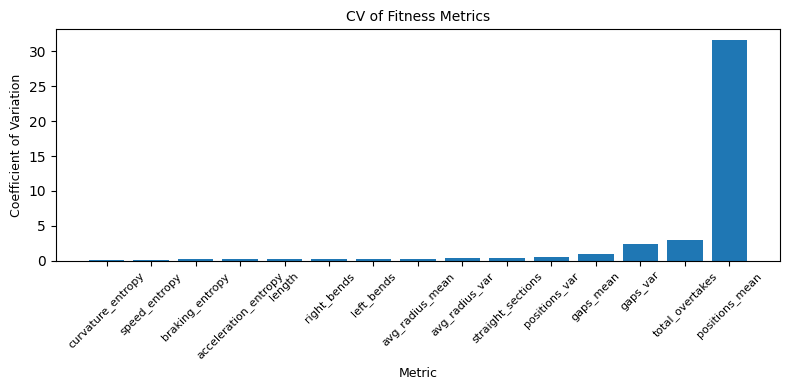

In [29]:
## Coefficient of Variation (CV)
#
# Compute and visualize the coefficient of variation for each fitness metric over all simulation runs.

# %% 
import numpy as np
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch

cv_values = {}
for metric in features:
    mean_val = df_all[metric].mean()
    std_val = df_all[metric].std()
    cv_values[metric] = std_val / abs(mean_val) if mean_val != 0 else np.nan

cv_df = pd.DataFrame(list(cv_values.items()), columns=["Metric", "CV"])
cv_df.sort_values("CV", inplace=True)
print("Coefficient of Variation (CV) for each metric:")
print(cv_df)

plt.figure(figsize=(8, 4))
plt.bar(cv_df["Metric"], cv_df["CV"])
plt.xlabel("Metric", fontsize=9)
plt.ylabel("Coefficient of Variation", fontsize=9)
plt.title("CV of Fitness Metrics", fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()

Compute and visualize the correlation matrix for all numeric features (including candidate fitness measures).

Correlation Matrix (all runs):
                        length    deltaX    deltaY  deltaAngleDegrees  \
length                1.000000 -0.041450 -0.001163          -0.080477   
deltaX               -0.041450  1.000000  0.000824          -0.201849   
deltaY               -0.001163  0.000824  1.000000          -0.040877   
deltaAngleDegrees    -0.080477 -0.201849 -0.040877           1.000000   
speed_entropy        -0.169153  0.150140  0.009859          -0.023622   
acceleration_entropy -0.182246  0.233814  0.035152          -0.023768   
braking_entropy      -0.080564  0.153630 -0.014325          -0.042828   
positions_mean        0.007320  0.072539 -0.035109          -0.019869   
avg_radius_mean       0.164834 -0.197180 -0.007584           0.019811   
gaps_mean             0.055578  0.135184 -0.014757          -0.051520   
right_bends           0.789112 -0.074945  0.005121           0.005853   
avg_radius_var        0.216906 -0.197663 -0.015882           0.026365   
total_overtakes     

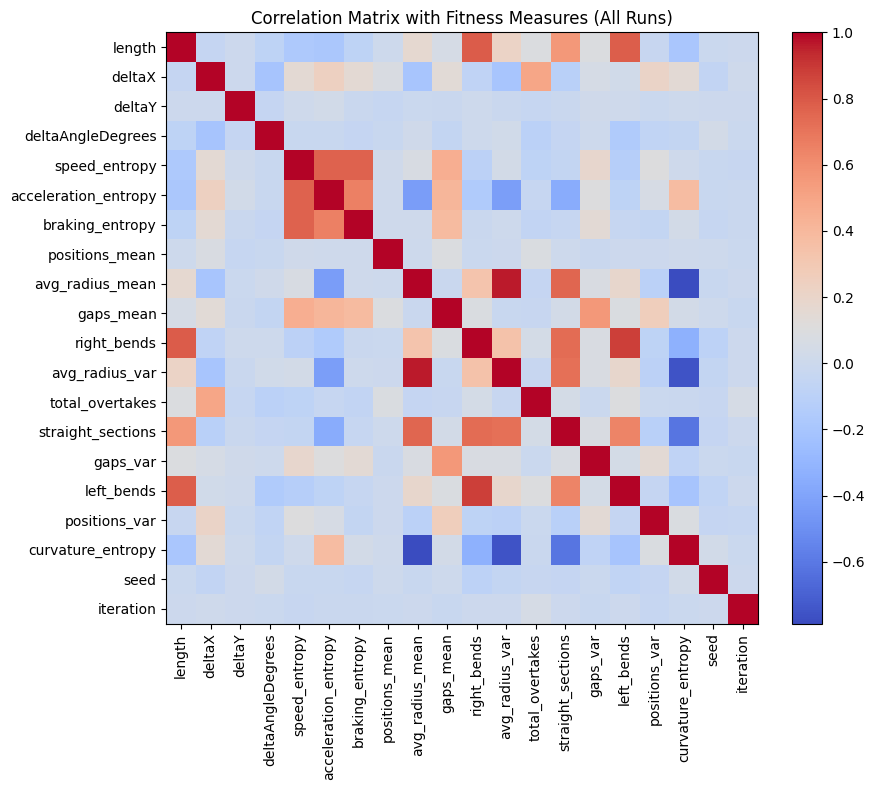


Significant Correlations (|r| >= 0.7) in all runs:
length & right_bends: 0.79
length & left_bends: 0.78
speed_entropy & acceleration_entropy: 0.77
speed_entropy & braking_entropy: 0.77
avg_radius_mean & avg_radius_var: 0.96
avg_radius_mean & straight_sections: 0.75
avg_radius_mean & curvature_entropy: -0.79
right_bends & straight_sections: 0.73
right_bends & left_bends: 0.88
avg_radius_var & straight_sections: 0.72
avg_radius_var & curvature_entropy: -0.75


In [31]:
# ## Correlation Analysis on all individual runs
#
# We then compute a correlation matrix for all numeric features based on all simulation runs.
# (In subsequent analysis we will work with averaged features for each seed.)

# %% 
corr_all = df_all.select_dtypes(include=[float, int]).corr()
print("Correlation Matrix (all runs):")
print(corr_all)

plt.figure(figsize=(10, 8))
cax = plt.imshow(corr_all, cmap='coolwarm', interpolation='nearest')
plt.title("Correlation Matrix with Fitness Measures (All Runs)")
plt.colorbar(cax, fraction=0.046, pad=0.04)
ticks = np.arange(len(corr_all.columns))
plt.xticks(ticks, corr_all.columns, rotation=90)
plt.yticks(ticks, corr_all.columns)
plt.tight_layout()
plt.show()

threshold = 0.7
print(f"\nSignificant Correlations (|r| >= {threshold:.1f}) in all runs:")
for i in range(len(corr_all.columns)):
    for j in range(i + 1, len(corr_all.columns)):
        if abs(corr_all.iloc[i, j]) >= threshold:
            print(f"{corr_all.columns[i]} & {corr_all.columns[j]}: {corr_all.iloc[i, j]:.2f}")


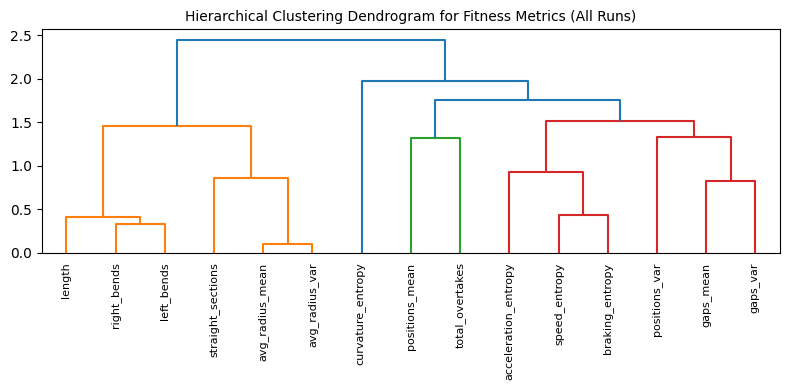

In [32]:
# ## Hierarchical Clustering of Fitness Metrics (All Runs)
#
# Hierarchical clustering helps us understand the relationships between features.
    
# %% 
corr_fitness_all = df_all[features].corr()
linked_all = sch.linkage(corr_fitness_all, method='average')

plt.figure(figsize=(8, 4))
dendro_all = sch.dendrogram(linked_all, labels=corr_fitness_all.columns, leaf_rotation=90, leaf_font_size=8)
plt.title("Hierarchical Clustering Dendrogram for Fitness Metrics (All Runs)", fontsize=10)
plt.tight_layout()
plt.show()

In [33]:
# Aggregation of Simulation Runs
#
# Now, we average the ten runs of each seed (for both voronoi and convexHull) to obtain one result per track.
# This aggregated data will be used for higher-level visual analyses (UMAP, TSNE, further correlation and clustering).

# %% 
df_avg = df_all.groupby(['technique', 'seed']).mean().reset_index()
print("Aggregated simulation data (averaged over 10 runs per seed):")
print(df_avg.head())

# For later analyses we define group_stats as the aggregated data.
group_stats = df_avg.copy()  # group_stats now contains one row per seed


Aggregated simulation data (averaged over 10 runs per seed):
    technique  seed       length    deltaX    deltaY  deltaAngleDegrees  \
0  convexHull     1  1086.185401  0.982397 -0.502335          -0.320711   
1  convexHull     2  1046.037866 -0.139001 -0.287430          -0.492892   
2  convexHull     3  1019.281751  0.201604  0.026691           0.467586   
3  convexHull     4  1014.635480 -0.991386  0.696570           0.158834   
4  convexHull     5  1056.844995  1.414367  0.104160          -0.397204   

   speed_entropy  acceleration_entropy  braking_entropy  positions_mean  ...  \
0       3.202942              1.914880         1.259926             0.0  ...   
1       3.004175              1.868266         1.147942             0.0  ...   
2       3.255823              2.064666         1.285476             0.0  ...   
3       3.142583              1.936625         1.284234             0.0  ...   
4       3.033990              1.857932         1.200297             0.0  ...   

   gaps

In [34]:
# # Dimensionality Reduction & Visual Mapping
#
# In this section, we load the JSON files that include the fixed-length spline vectors.
# Since all simulation runs from a given seed yield the same track geometry, we load only one spline vector per seed.
# We combine the unique tracks from both the voronoi and convexHull folders, then apply t-SNE and UMAP to project the high-dimensional track features into a 2D space.
# Finally, we visualize the 2D embeddings to evaluate the visual diversity and assess the relationship between the track descriptors and the aggregated fitness metrics.

# %% 
import numpy as np
from sklearn.manifold import TSNE
import umap

def load_unique_spline_features(data_dirs):
    unique_features = {}  # key: (technique, seed) -> spline vector
    for tech, folder in data_dirs.items():
        for fname in os.listdir(folder):
            if not fname.endswith('.json'):
                continue
            base = os.path.splitext(fname)[0]
            parts = base.split('_')
            if len(parts) < 2:
                continue
            try:
                seed = int(parts[0])
            except Exception:
                continue
            # Use the first encountered file for each (technique, seed)
            if (tech, seed) not in unique_features:
                path = os.path.join(folder, fname)
                try:
                    with open(path, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                    if 'splineVector' not in data:
                        continue
                    spline = data['splineVector']
                    vec = []
                    for point in spline:
                        vec.extend([point.get('x', 0), point.get('y', 0)])
                    unique_features[(tech, seed)] = vec
                except Exception as e:
                    print(f"Error reading {fname}: {e}")
    features_list = list(unique_features.values())
    track_ids = [f"{tech}_{seed}" for (tech, seed) in unique_features.keys()]
    return np.array(features_list), track_ids

# Load unique spline vectors from both directories.
X_spline, track_ids = load_unique_spline_features(DATA_DIRS)
print(f"Loaded {X_spline.shape[0]} unique tracks with feature dimension {X_spline.shape[1]}.")


Loaded 200 unique tracks with feature dimension 200.


c:\Users\batman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\batman\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\batman\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\batman\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as

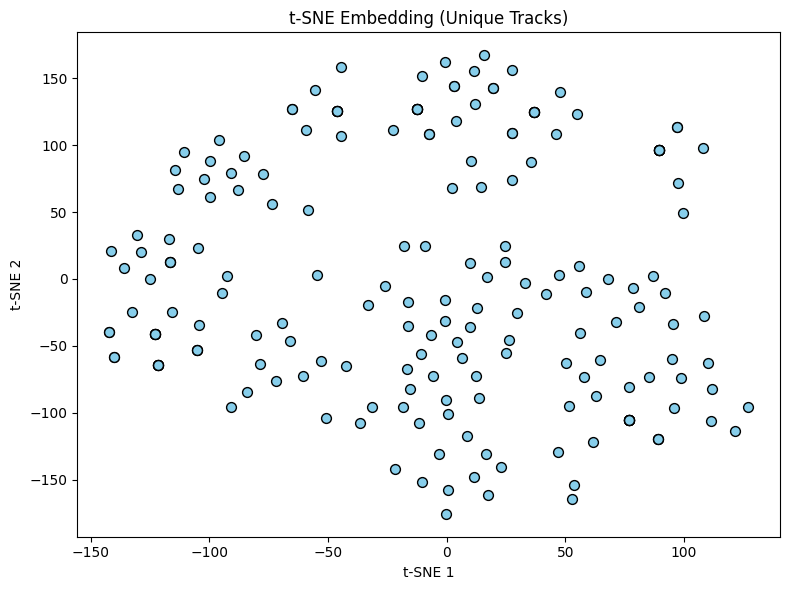

In [35]:
# ## t-SNE Embedding of Spline Vectors
#
# We now map the high-dimensional spline feature vectors into a 2D space using t-SNE.

# %% 
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_spline)
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], edgecolor='k', s=50, color='skyblue')
plt.title("t-SNE Embedding (Unique Tracks)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


c:\Users\batman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\batman\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


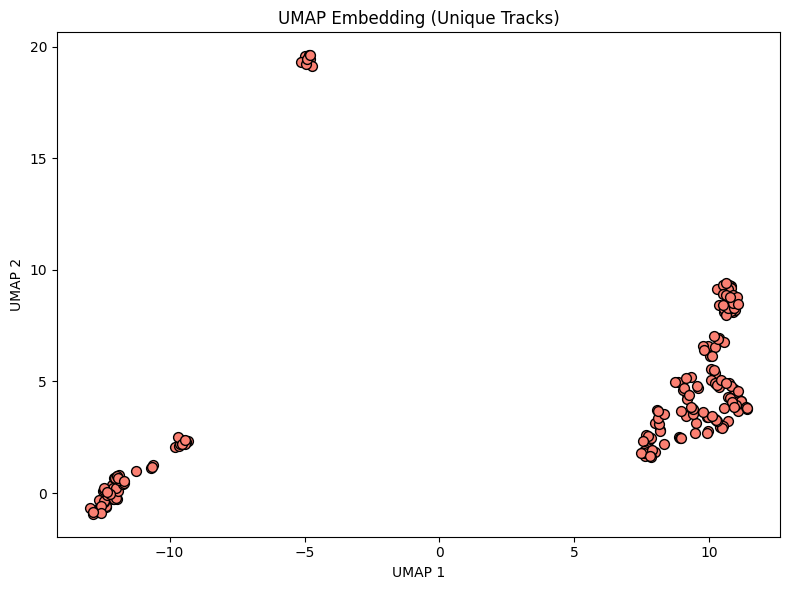

In [36]:
# ## UMAP Embedding of Spline Vectors
#
# We apply UMAP as an alternative dimensionality reduction technique.

# %% 
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_spline)
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], edgecolor='k', s=50, color='salmon')
plt.title("UMAP Embedding (Unique Tracks)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()

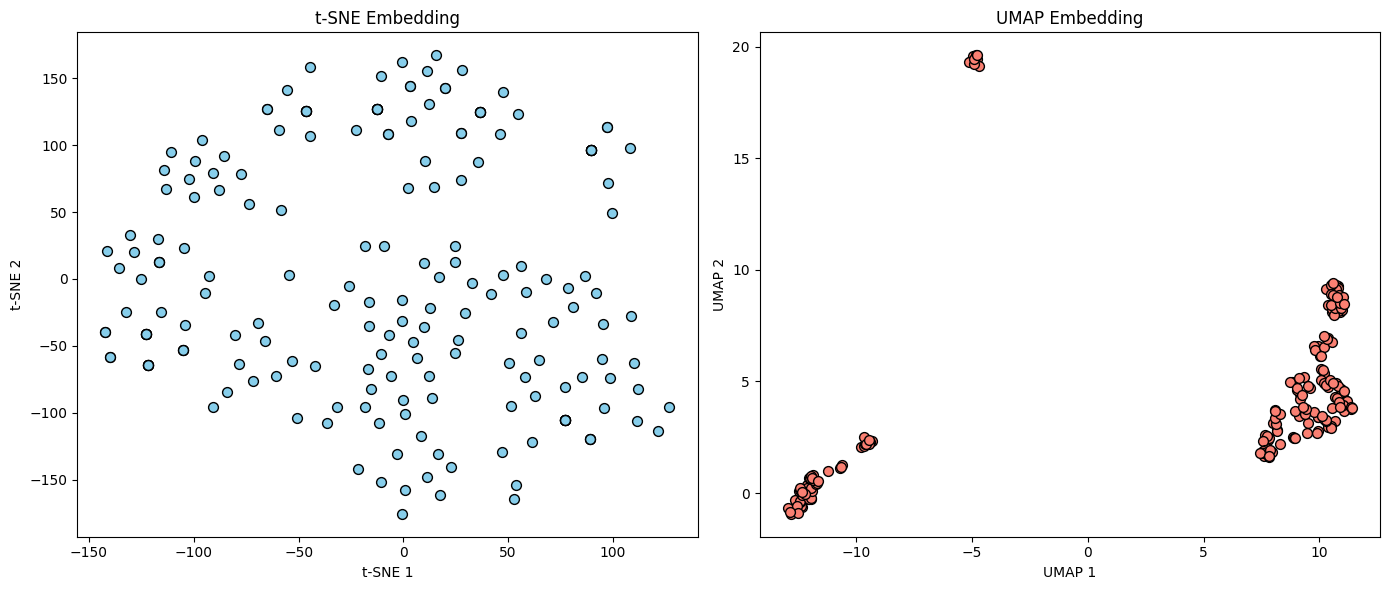

In [37]:
# ## Comparing t-SNE and UMAP Embeddings
#
# Here we display both embeddings side by side for visual comparison.

# %% 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], edgecolor='k', s=50, color='skyblue')
ax1.set_title("t-SNE Embedding")
ax1.set_xlabel("t-SNE 1")
ax1.set_ylabel("t-SNE 2")
ax2.scatter(X_umap[:, 0], X_umap[:, 1], edgecolor='k', s=50, color='salmon')
ax2.set_title("UMAP Embedding")
ax2.set_xlabel("UMAP 1")
ax2.set_ylabel("UMAP 2")
plt.tight_layout()
plt.show()

Correlation Matrix (Aggregated Data):
                          seed    length    deltaX    deltaY  \
seed                  1.000000 -0.007671 -0.072935  0.000298   
length               -0.007671  1.000000 -0.049298 -0.008711   
deltaX               -0.072935 -0.049298  1.000000 -0.044259   
deltaY                0.000298 -0.008711 -0.044259  1.000000   
deltaAngleDegrees     0.066273 -0.148629 -0.325034  0.020564   
speed_entropy        -0.044608 -0.355862  0.199231 -0.035767   
acceleration_entropy -0.037517 -0.299727  0.379303  0.016181   
braking_entropy      -0.078827 -0.180308  0.241229 -0.058973   
positions_mean        0.012901  0.023017  0.163549 -0.196953   
avg_radius_mean      -0.024738  0.163070 -0.264692 -0.025791   
gaps_mean             0.018734  0.119515  0.212869 -0.052725   
right_bends          -0.087296  0.792263 -0.091113  0.015184   
avg_radius_var       -0.050206  0.215439 -0.264755 -0.051760   
total_overtakes      -0.057869  0.192643  0.640614 -0.122358   
st

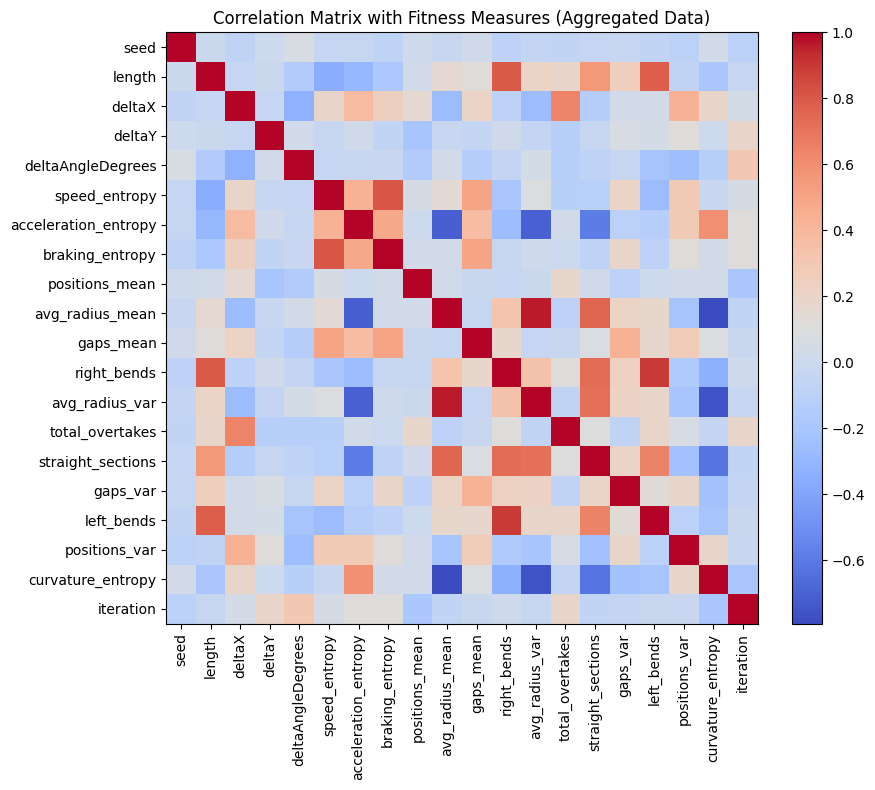

In [38]:
# ## Correlation Analysis on Aggregated Data
#
# With the simulation results averaged per seed (stored in `group_stats`), we now re-compute the correlation matrix and visualize it.
    
# %% 
corr_avg = group_stats.select_dtypes(include=[float, int]).corr()
print("Correlation Matrix (Aggregated Data):")
print(corr_avg)

plt.figure(figsize=(10, 8))
cax_avg = plt.imshow(corr_avg, cmap='coolwarm', interpolation='nearest')
plt.title("Correlation Matrix with Fitness Measures (Aggregated Data)")
plt.colorbar(cax_avg, fraction=0.046, pad=0.04)
ticks = np.arange(len(corr_avg.columns))
plt.xticks(ticks, corr_avg.columns, rotation=90)
plt.yticks(ticks, corr_avg.columns)
plt.tight_layout()
plt.show()

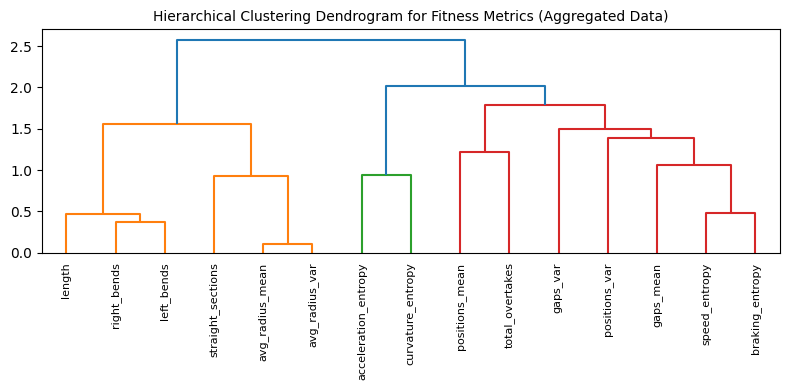

In [39]:
# ## Hierarchical Clustering on Aggregated Data
#
# We perform hierarchical clustering using the aggregated fitness metrics.

# %% 
corr_fitness_avg = group_stats[features].corr()
linked_avg = sch.linkage(corr_fitness_avg, method='average')

plt.figure(figsize=(8, 4))
dendro_avg = sch.dendrogram(linked_avg, labels=corr_fitness_avg.columns, leaf_rotation=90, leaf_font_size=8)
plt.title("Hierarchical Clustering Dendrogram for Fitness Metrics (Aggregated Data)", fontsize=10)
plt.tight_layout()
plt.show()


In [40]:
# ## Visualizing Fitness Descriptors on the UMAP Map
#
# Finally, we combine the UMAP embedding with the aggregated fitness descriptors to examine how selected metrics relate to the 2D coordinates.
    
# %% 
import math

def visualize_fitness_descriptors_on_umap(track_ids, X_umap, group_stats, fitness_metric_suffix='_mean', grid_cols=3):
    """
    Combines UMAP embedding with fitness descriptors and visualizes each fitness metric on a UMAP scatter plot.
    """
    umap_df = pd.DataFrame({
        'id': track_ids,  # unique track ids e.g., "voronoi_23"
        'umap_1': X_umap[:, 0],
        'umap_2': X_umap[:, 1]
    })
    # Attempt to convert 'id' to extract seed (assuming format "tech_seed")
    try:
        umap_df['seed'] = umap_df['id'].apply(lambda x: int(x.split('_')[1]))
    except Exception as e:
        print("Error extracting seed from id:", e)
        umap_df['seed'] = umap_df['id']
    
    # Prepare the fitness DataFrame (aggregated by track seed)
    fitness_df = group_stats.copy()
    # Rename 'seed' column (if needed) to match for merging
    fitness_df.rename(columns={'seed': 'seed'}, inplace=True)
    
    # Merge the UMAP data with the fitness descriptors
    merged_df = pd.merge(umap_df, fitness_df, left_on='seed', right_on='seed', how='inner')
    print("Merged DataFrame shape:", merged_df.shape)
    
    # Automatically determine all metrics based on columns ending with the given suffix
    metric_names = [col.replace(fitness_metric_suffix, '') for col in merged_df.columns if col.endswith(fitness_metric_suffix)]
    print("Fitness metrics to visualize:", metric_names)
    
    n_metrics = len(metric_names)
    rows = math.ceil(n_metrics / grid_cols)
    fig, axes = plt.subplots(rows, grid_cols, figsize=(grid_cols*4, rows*4), squeeze=False)
    
    for i, metric in enumerate(metric_names):
        ax = axes[i // grid_cols, i % grid_cols]
        color_col = f"{metric}{fitness_metric_suffix}"
        sc = ax.scatter(merged_df['umap_1'], merged_df['umap_2'],
                        c=merged_df[color_col], cmap='viridis', edgecolor='k', s=50)
        ax.set_title(metric, fontsize=10)
        ax.set_xlabel("UMAP 1", fontsize=8)
        ax.set_ylabel("UMAP 2", fontsize=8)
        cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
        cbar.ax.tick_params(labelsize=8)
        corr_umap1 = np.corrcoef(merged_df['umap_1'], merged_df[color_col])[0, 1]
        corr_umap2 = np.corrcoef(merged_df['umap_2'], merged_df[color_col])[0, 1]
        ax.annotate(f"r(UMAP1)={corr_umap1:.2f}\nr(UMAP2)={corr_umap2:.2f}", 
                    xy=(0.05, 0.95), xycoords='axes fraction', fontsize=8,
                    verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.5))
    
    for j in range(i + 1, rows * grid_cols):
        fig.delaxes(axes[j // grid_cols, j % grid_cols])
    
    plt.tight_layout()
    plt.show()

Merged DataFrame shape: (400, 24)
Selected fitness metrics to visualize: ['speed_entropy', 'curvature_entropy', 'braking_entropy', 'gaps_mean', 'total_overtakes']


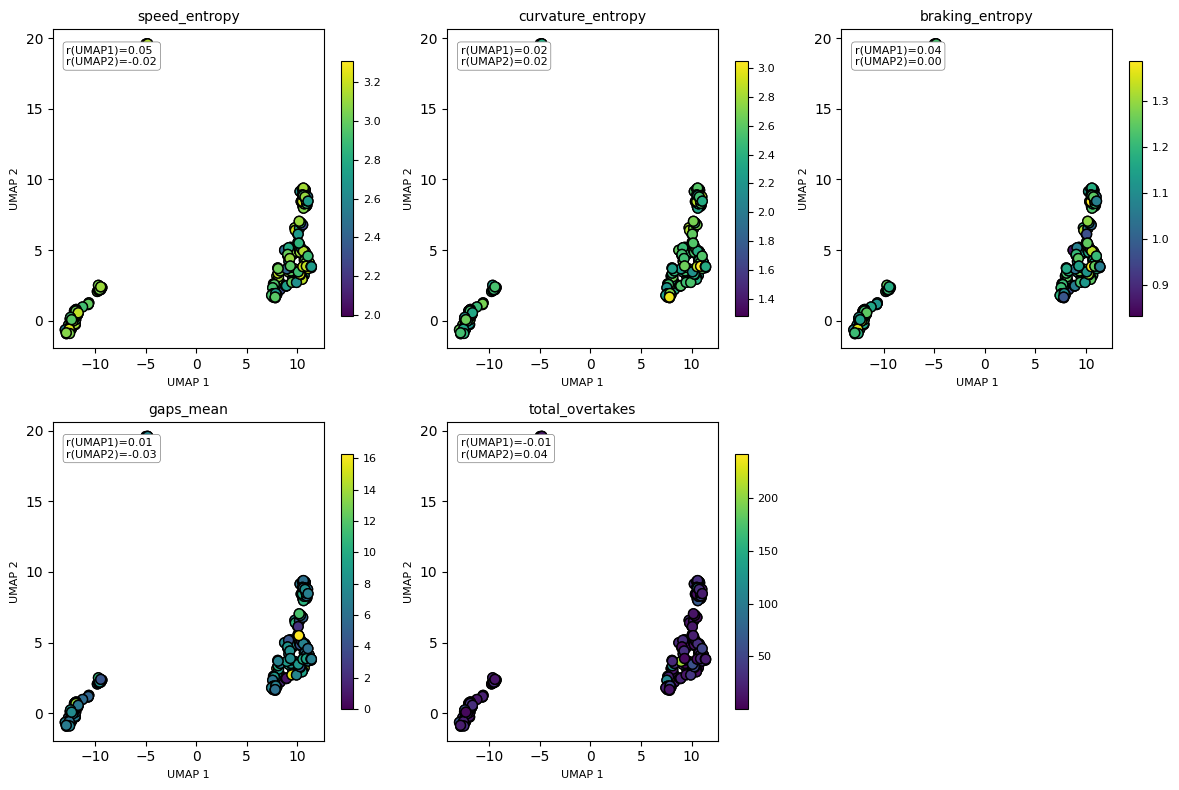

High curvature track (aggregated):
 seed                       95
technique             voronoi
curvature_entropy    3.044923
Name: 194, dtype: object

Low curvature track (aggregated):
 seed                       17
technique             voronoi
curvature_entropy    1.281929
Name: 116, dtype: object


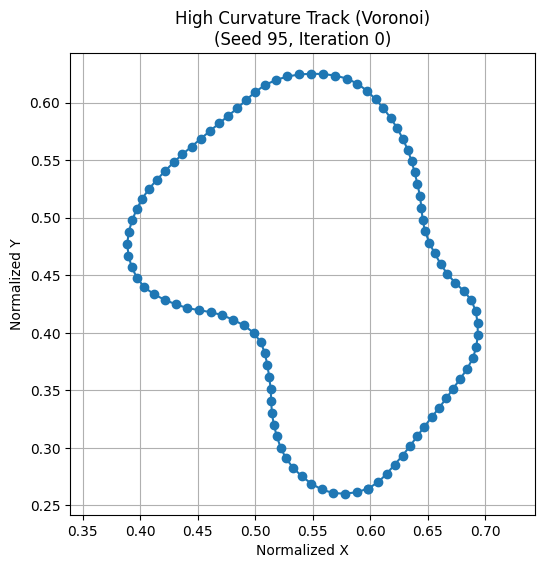

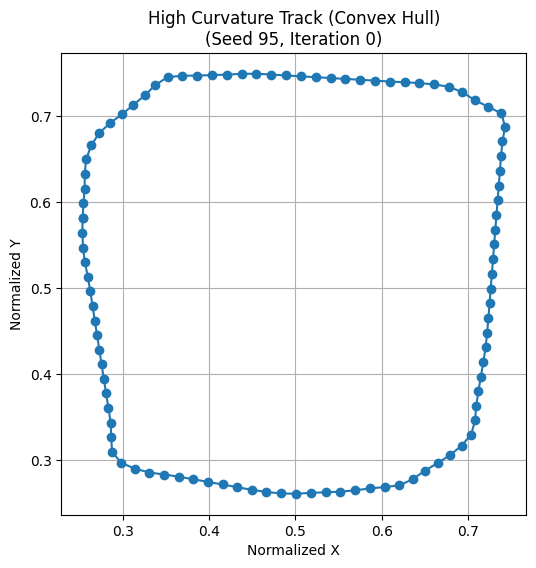

No spline found for seed 17, iteration 0


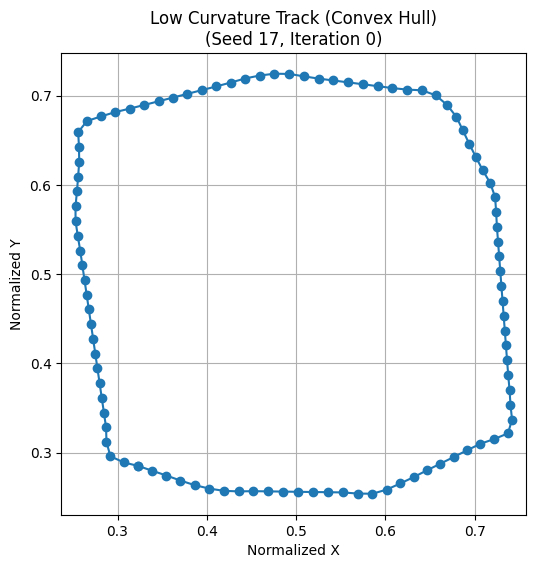

In [44]:
# %% [markdown]
# ## Visualizing Selected Fitness Descriptors on the UMAP Map
#
# Here, we focus on a subset of fitness metrics:
# - speed_entropy
# - curvature_entropy
# - braking_entropy
# - gaps_mean
# - total_overtakes
#
# These metrics will be visualized on the UMAP projection of the unique track spline vectors,
# using the aggregated (averaged) simulation data (group_stats).

# %% 
import math

def visualize_fitness_descriptors_on_umap(track_ids, X_umap, group_stats, selected_metrics=None, fitness_metric_suffix='', grid_cols=3):
    """
    Combines UMAP embedding with selected fitness descriptors and visualizes each on a UMAP scatter plot.
    
    Parameters:
      - track_ids: List or array of unique track identifiers (e.g., "voronoi_23").
      - X_umap: UMAP embedding array (2D) with shape (n_tracks, 2).
      - group_stats: DataFrame containing aggregated fitness metrics for each track (one row per seed).
      - selected_metrics: List of selected metrics to visualize; if None, all metrics ending with `fitness_metric_suffix` are used.
      - fitness_metric_suffix: Suffix to identify the fitness metric columns. Set to an empty string if columns are named directly.
      - grid_cols: Number of columns in the subplot grid.
    """
    # Create a DataFrame from the UMAP embedding. The 'id' here is assumed to be in the format "tech_seed"
    umap_df = pd.DataFrame({
        'id': track_ids,
        'umap_1': X_umap[:, 0],
        'umap_2': X_umap[:, 1]
    })
    # Extract seed from the id assuming format "tech_seed"
    try:
        umap_df['seed'] = umap_df['id'].apply(lambda x: int(x.split('_')[1]))
    except Exception as e:
        print("Error extracting seed from id:", e)
        umap_df['seed'] = umap_df['id']
    
    # Ensure that group_stats has a column named 'seed'
    fitness_df = group_stats.copy()
    # Merge UMAP embedding with fitness metrics on seed
    merged_df = pd.merge(umap_df, fitness_df, on='seed', how='inner')
    print("Merged DataFrame shape:", merged_df.shape)
    
    # If selected_metrics is provided, use it; otherwise, scan for columns ending with the suffix.
    if selected_metrics is not None:
        metric_names = selected_metrics
    else:
        metric_names = [col.replace(fitness_metric_suffix, '') 
                        for col in merged_df.columns if col.endswith(fitness_metric_suffix) 
                        and col.replace(fitness_metric_suffix, '') not in ['seed']]
    print("Selected fitness metrics to visualize:", metric_names)
    
    n_metrics = len(metric_names)
    rows = math.ceil(n_metrics / grid_cols)
    fig, axes = plt.subplots(rows, grid_cols, figsize=(grid_cols * 4, rows * 4), squeeze=False)
    
    for i, metric in enumerate(metric_names):
        ax = axes[i // grid_cols, i % grid_cols]
        # Construct the expected column name
        color_col = f"{metric}{fitness_metric_suffix}"
        if color_col not in merged_df.columns:
            print(f"Metric {color_col} not found in merged data; skipping.")
            continue
        sc = ax.scatter(merged_df['umap_1'], merged_df['umap_2'],
                        c=merged_df[color_col], cmap='viridis', edgecolor='k', s=50)
        ax.set_title(metric, fontsize=10)
        ax.set_xlabel("UMAP 1", fontsize=8)
        ax.set_ylabel("UMAP 2", fontsize=8)
        cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
        cbar.ax.tick_params(labelsize=8)
        corr_umap1 = np.corrcoef(merged_df['umap_1'], merged_df[color_col])[0, 1]
        corr_umap2 = np.corrcoef(merged_df['umap_2'], merged_df[color_col])[0, 1]
        ax.annotate(f"r(UMAP1)={corr_umap1:.2f}\nr(UMAP2)={corr_umap2:.2f}",
                    xy=(0.05, 0.95), xycoords='axes fraction', fontsize=8,
                    verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.5))
    
    # Remove any extra subplots
    for j in range(i + 1, rows * grid_cols):
        fig.delaxes(axes[j // grid_cols, j % grid_cols])
    
    plt.tight_layout()
    plt.show()


# Define the selected fitness metrics
selected_metrics = ["speed_entropy", "curvature_entropy", "braking_entropy", "gaps_mean", "total_overtakes"]

# Visualize descriptors using the aggregated data (group_stats is created from df_avg)
visualize_fitness_descriptors_on_umap(track_ids, X_umap, group_stats, selected_metrics=selected_metrics, fitness_metric_suffix='', grid_cols=3)

# %% [markdown]
# ## Additional: Visualizing Individual Tracks
#
# The following functions load and visualize the spline vector of a track from a given folder.
    
# %% 
import glob
import os

def load_spline_vector(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    if "splineVector" in data:
        pts = data["splineVector"]
        xs = [pt["x"] for pt in pts]
        ys = [pt["y"] for pt in pts]
        return xs, ys
    return None, None

def visualize_track(folder, seed, iteration=0, title='Track Visualization'):
    file_path = os.path.join(folder, f"{seed}_{iteration}.json")
    xs, ys = load_spline_vector(file_path)
    if xs is None:
        print(f"No spline found for seed {seed}, iteration {iteration}")
        return
    plt.figure(figsize=(6,6))
    plt.plot(xs, ys, marker='o')
    plt.title(f"{title}\n(Seed {seed}, Iteration {iteration})")
    plt.xlabel("Normalized X")
    plt.ylabel("Normalized Y")
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# Identify one high-curvature track and one low-curvature track from the aggregated data.
# (Here we sort based on 'curvature_entropy'.)
high_curvature_entropy = df_avg.sort_values(['curvature_entropy'], ascending=False).iloc[0]
low_curvature_entropy = df_avg.sort_values(['curvature_entropy']).iloc[0]

print("High curvature track (aggregated):\n", high_curvature_entropy[['seed','technique','curvature_entropy']])
print("\nLow curvature track (aggregated):\n", low_curvature_entropy[['seed','technique','curvature_entropy']])

seed_high = high_curvature_entropy['seed']
seed_low = low_curvature_entropy['seed']

# Visualize the selected track for both techniques.
visualize_track(DATA_DIRS['voronoi'], seed_high, title='High Curvature Track (Voronoi)')
visualize_track(DATA_DIRS['convexHull'], seed_high, title='High Curvature Track (Convex Hull)')
visualize_track(DATA_DIRS['voronoi'], seed_low, title='Low Curvature Track (Voronoi)')
visualize_track(DATA_DIRS['convexHull'], seed_low, title='Low Curvature Track (Convex Hull)')


# Dimensionality Reduction & Visual Mapping

In this section, we load the JSON files that include the fixed-length spline vectors.
We convert these spline representations into a flattened feature vector for each track.
Then, we apply t-SNE and UMAP to project the high-dimensional track features into a 2D space.
Finally, we visualize the 2D embeddings to evaluate the visual diversity and see how the descriptors (represented by the 2D coordinates) relate to our other metrics.

In [ ]:
from sklearn.manifold import TSNE
import umap

track_ids = []
spline_features = []
meta_data = []

for filename in os.listdir(DATA_DIR):
    if not filename.endswith('.json'):
        continue
    filepath = os.path.join(DATA_DIR, filename)
    try:
        with open(filepath, 'r', encoding='utf-8') as file:
            genotype = json.load(file)
        if 'splineVector' not in genotype:
            continue
        spline = genotype['splineVector']
        feature_vector = []
        for point in spline:
            feature_vector.extend([point['x'], point['y']])
        spline_features.append(feature_vector)
        track_ids.append(genotype.get('id', filename))
        meta_data.append({
            'id': genotype.get('id', filename),
            'mode': genotype.get('mode'),
            'trackSize': genotype.get('trackSize'),
        })
    except Exception as e:
        print(f"Error reading {filename}: {e}")

import numpy as np

X = np.array(spline_features)
print(f"Loaded {X.shape[0]} tracks with feature dimension {X.shape[1]}.")

t-SNE Embedding
Map the spline feature vectors to a 2D space using t-SNE.

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='skyblue', edgecolor='k')
plt.title("t-SNE Embedding of Track Spline Representations")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

## UMAP Embedding

Apply UMAP as an alternative dimensionality reduction technique.

In [ ]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c='salmon', edgecolor='k')
plt.title("UMAP Embedding of Track Spline Representations")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()


Comparing the Embeddings
Display both t-SNE and UMAP embeddings side by side for visual comparison.
Optionally, further analysis can correlate these 2D coordinates with other metrics.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], c='skyblue', edgecolor='k')
ax1.set_title("t-SNE Embedding")
ax1.set_xlabel("t-SNE 1")
ax1.set_ylabel("t-SNE 2")

ax2.scatter(X_umap[:, 0], X_umap[:, 1], c='salmon', edgecolor='k')
ax2.set_title("UMAP Embedding")
ax2.set_xlabel("UMAP 1")
ax2.set_ylabel("UMAP 2")

plt.tight_layout()
plt.show()


Correlate the 2D embedding coordinates with additional descriptors (e.g., noise metrics, overtaking scores).
- Use the embedding coordinates as descriptors for clustering or regression analyses.
- Experiment with hyperparameters (e.g., t-SNE perplexity, UMAP n_neighbors) to assess their impact.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

def visualize_fitness_descriptors_on_umap(track_ids, X_umap, group_stats, fitness_metric_suffix='_mean', grid_cols=3):
    """
    Combines UMAP embedding with fitness descriptors and visualizes each fitness metric on a UMAP scatter plot.
    
    Parameters:
      - track_ids: List or array of track identifiers (from the spline vector loop).
      - X_umap: UMAP embedding array (2D) of shape (n_tracks, 2).
      - group_stats: DataFrame of aggregated fitness descriptors per track (with a 'seed' column).
      - fitness_metric_suffix: Suffix for fitness metric columns (default '_mean').
      - grid_cols: Number of columns in the subplot grid.
    """
    
    # Create a DataFrame from the UMAP embedding
    umap_df = pd.DataFrame({
        'id': track_ids,  # from the spline vector loop
        'umap_1': X_umap[:, 0],
        'umap_2': X_umap[:, 1]
    })
    
    # Attempt to convert 'id' to integer for merging with the fitness data (which uses 'seed')
    try:
        umap_df['id'] = umap_df['id'].astype(int)
    except Exception as e:
        print("Could not convert 'id' to int, merging based on string values:", e)
    
    # Prepare the fitness DataFrame (aggregated by track seed) by renaming 'seed' to 'id'
    fitness_df = group_stats.copy()
    fitness_df.rename(columns={'seed': 'id'}, inplace=True)
    
    # Merge the UMAP data with the fitness descriptors
    merged_df = pd.merge(umap_df, fitness_df, on='id', how='inner')
    print("Merged DataFrame shape:", merged_df.shape)
    
    # Automatically determine all metrics (fitness descriptors) based on columns ending with the given suffix
    metric_names = [col.replace(fitness_metric_suffix, '') for col in merged_df.columns if col.endswith(fitness_metric_suffix)]
    print("Fitness metrics to visualize:", metric_names)
    
    # Set up a grid for subplots
    n_metrics = len(metric_names)
    rows = math.ceil(n_metrics / grid_cols)
    fig, axes = plt.subplots(rows, grid_cols, figsize=(grid_cols*4, rows*4), squeeze=False)
    
    # Loop through each metric and create the UMAP scatter plot
    for i, metric in enumerate(metric_names):
        ax = axes[i // grid_cols, i % grid_cols]
        color_col = f"{metric}{fitness_metric_suffix}"  # use the mean value of the fitness metric
        sc = ax.scatter(merged_df['umap_1'], merged_df['umap_2'],
                        c=merged_df[color_col], cmap='viridis', edgecolor='k', s=50)
        ax.set_title(metric, fontsize=10)
        ax.set_xlabel("UMAP 1", fontsize=8)
        ax.set_ylabel("UMAP 2", fontsize=8)
        cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
        cbar.ax.tick_params(labelsize=8)
        
        # Compute Pearson correlations between the fitness metric and the UMAP axes
        corr_umap1 = np.corrcoef(merged_df['umap_1'], merged_df[color_col])[0, 1]
        corr_umap2 = np.corrcoef(merged_df['umap_2'], merged_df[color_col])[0, 1]
        ax.annotate(f"r(UMAP1)={corr_umap1:.2f}\nr(UMAP2)={corr_umap2:.2f}", 
                    xy=(0.05, 0.95), xycoords='axes fraction', fontsize=8,
                    verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.5))
    
    # Remove any empty subplots if the grid is larger than needed
    for j in range(i + 1, rows * grid_cols):
        fig.delaxes(axes[j // grid_cols, j % grid_cols])
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assume track_ids, X_umap, and group_stats are already defined from your earlier analysis
visualize_fitness_descriptors_on_umap(track_ids, X_umap, group_stats)


In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import umap

def load_spline_features(folder, technique):
    features = []
    ids = []
    for fname in os.listdir(folder):
        if not fname.endswith('.json'):
            continue
        path = os.path.join(folder, fname)
        try:
            with open(path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            spline = data.get('splineVector')
            if not spline:
                continue
            vec = []
            for point in spline:
                vec.extend([point.get('x', 0), point.get('y', 0)])
            features.append(vec)
            ids.append(data.get('id', fname))
        except Exception as e:
            print(f"Error reading {fname}: {e}")
    return np.array(features), ids

# Esempio di caricamento delle spline per i tracciati Voronoi (ripeti similmente per convexHull se necessario)
X_voronoi, track_ids_voronoi = load_spline_features(DATA_DIRS['voronoi'], 'voronoi')
print(f"Caricate {X_voronoi.shape[0]} tracce con {X_voronoi.shape[1]} feature da Voronoi.")

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_voronoi)
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], edgecolor='k', s=50, color='skyblue')
plt.title("t-SNE Embedding (Voronoi)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

# UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_voronoi)
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], edgecolor='k', s=50, color='salmon')
plt.title("UMAP Embedding (Voronoi)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()


In [ ]:
high_curvature_entropy = df_all.sort_values(['curvature_entropy', 'speed_entropy'], ascending=False).iloc[0]
low_curvature_entropy = df_all.sort_values(['curvature_entropy', 'speed_entropy']).iloc[0]

print("High curvature & entropy track:\n", high_curvature_entropy[['seed','technique','curvature_entropy','speed_entropy']])
print("\nLow curvature & entropy track:\n", low_curvature_entropy[['seed','technique','curvature_entropy','speed_entropy']])


In [ ]:
import json
import matplotlib.pyplot as plt
import glob
import os

def load_spline_vector(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    if "splineVector" in data:
        pts = data["splineVector"]
        xs = [pt["x"] for pt in pts]
        ys = [pt["y"] for pt in pts]
        return xs, ys
    return None, None

def visualize_track(folder, seed, iteration=0, title='Track Visualization'):
    file_path = os.path.join(folder, f"{seed}_{iteration}.json")
    xs, ys = load_spline_vector(file_path)
    if xs is None:
        print(f"No spline found for seed {seed}, iteration {iteration}")
        return
    plt.figure(figsize=(6,6))
    plt.plot(xs, ys, marker='o')
    plt.title(f"{title}\n(Seed {seed}, Iteration {iteration})")
    plt.xlabel("Normalized X")
    plt.ylabel("Normalized Y")
    plt.grid(True)
    plt.axis('equal')
    plt.show()


In [ ]:
high_curvature_entropy = df_all.sort_values(['curvature_entropy', 'speed_entropy'], ascending=False).iloc[0]
low_curvature_entropy = df_all.sort_values(['curvature_entropy', 'speed_entropy']).iloc[0]

print("High curvature & entropy track:\n", high_curvature_entropy[['seed','technique','curvature_entropy','speed_entropy']])
print("\nLow curvature & entropy track:\n", low_curvature_entropy[['seed','technique','curvature_entropy','speed_entropy']])

feature_noiseness = df_all.groupby('seed')[features].std().mean().sort_values(ascending=False)
print("Feature noiseness (high to low):\n", feature_noiseness)

stable_features = feature_noiseness.tail(5)
print("\nStable (low noise) candidates:\n", stable_features)


In [ ]:
seed_high = high_curvature_entropy['seed']
# Visualize High Curvature & Entropy Tracks
visualize_track(DATA_DIRS['voronoi'], seed_high, title='High Curvature & Entropy Track (Voronoi)')
visualize_track(DATA_DIRS['convexHull'], seed_high, title='High Curvature & Entropy Track (Convex Hull)')
seed_low = low_curvature_entropy['seed']
# Visualize Low Curvature & Entropy Tracks
visualize_track(DATA_DIRS['voronoi'], seed_low, title='Low Curvature & Entropy Track (Voronoi)')
visualize_track(DATA_DIRS['convexHull'], seed_low, title='Low Curvature & Entropy Track (Convex Hull)')
